# Dynamical Mode Decomposition
In this textbook example, we show how `kooplearn` can produce the dynamical mode decomposition of a fluid flow with very few effort.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from kooplearn.kernel import KernelRidge
from kooplearn.preprocessing import FeatureFlattener
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [34]:
subsample_factor = 4
flow=np.load("Re_769.npz")
X = flow['data'][:, ::subsample_factor, ::subsample_factor, :]
geometry = np.load("input_geometry.npz")['mask'][::subsample_factor, ::subsample_factor]
def mask_img(img):
    masked_img = np.where(geometry, img, np.nan)
    return masked_img

In [17]:
# Standardize data. Can't use sklearn standard scaler, as it improperly handles multi-dimensional data.
class FlowScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Save shape for inverse_transform
        self.mean_ = np.mean(X, axis =(0, 1, 2), keepdims=True)
        self.std_ = np.std(X, axis =(0, 1, 2), keepdims=True)
        return self

    def transform(self, X, y=None):
        _X = (X - self.mean_)/self.std_
        return _X

    def inverse_transform(self, X, y=None):
        _X =  X*self.std_ + self.mean_
        return _X

In [18]:
flattener = FeatureFlattener()
scaler = FlowScaler()
data_pipe = Pipeline([("scaler", scaler),("flattener", flattener)])
data_pipe = data_pipe.fit(X)

In [97]:
model = KernelRidge(n_components=128, reduced_rank=False, alpha=1e-5)

In [98]:
model.fit(data_pipe.transform(X))
# Compute the dynamical modes
dmd = model.dynamical_modes(data_pipe.transform(X))

/Users/pietronovelli/code_repos/kooplearn/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


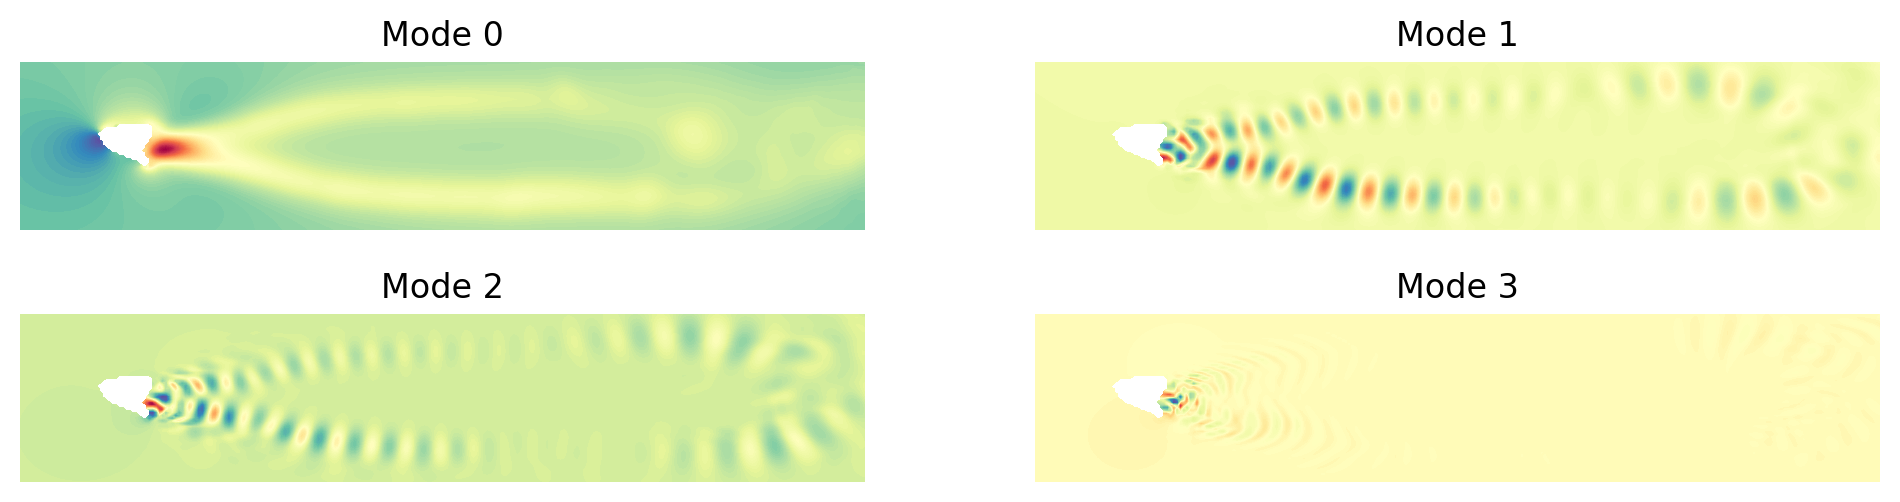

In [104]:
# Some nice plots
t_id = 100
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 3), dpi=200)
for mode_idx, ax in enumerate(axs.flatten()):
    u = data_pipe.inverse_transform(dmd[mode_idx])[..., 0]
    v = data_pipe.inverse_transform(dmd[mode_idx])[..., 1]
    p = data_pipe.inverse_transform(dmd[mode_idx])[..., 2]
    x, y = np.meshgrid(np.linspace(0, 5, 1024)[::subsample_factor], np.linspace(0, 1, 256)[::subsample_factor])
    ax.set_aspect('equal')
    pressure = ax.contourf(x, y, mask_img(p[t_id]), 100, cmap='Spectral')
    #ax.streamplot(x, y, u[t_id], v[t_id], color='black', linewidth=0.2, arrowsize=0.2)
    ax.set_axis_off()
    ax.set_title(f"Mode {mode_idx}")